In [5]:
import torch
from transformers import BertModel, BertTokenizer
import json
import os

# 1. 加载 BERT 模型和 tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 2. 定义一个字典来存储激活值
activations = {}

# 3. 定义钩子函数来捕获特定位置的激活值
def hook_fn(layer_name, target_token_idx):
    def hook(module, input, output):
        # 获取特定token位置的激活值
        # output的形状为 (batch_size, seq_len, hidden_size)
        # 我们选定目标token的位置target_token_idx
        target_activation = output.detach().cpu().numpy()[:, target_token_idx, :]
        activations[layer_name] = target_activation.tolist()
    return hook

# 4. 注册钩子：遍历所有 Transformer 层并注册钩子
hooks = []
input_text = "Hello, how are you?"

# 5. 将输入文本转换为token，并获取目标token的位置（如[CLS]或某个token）
inputs = tokenizer(input_text, return_tensors="pt")
tokens = tokenizer.tokenize(input_text)

# 假设我们想要获取第一个token（[CLS]）的位置
target_token_idx = 0  # [CLS]通常是第一个token

# 6. 注册钩子到每一层的 intermediate.dense（FFN部分）
for i, layer in enumerate(model.encoder.layer):
    hook = layer.intermediate.dense.register_forward_hook(hook_fn(f"layer_{i}_ffn", target_token_idx))
    hooks.append(hook)

# 7. 执行前向传播
outputs = model(**inputs)

# 8. 保存激活值到硬盘（保存为 JSON 格式）
save_dir = "./activations"
os.makedirs(save_dir, exist_ok=True)

# 保存路径
activation_file_path = os.path.join(save_dir, "activations.json")

# 将激活值字典保存为 JSON 文件
with open(activation_file_path, 'w') as json_file:
    json.dump(activations, json_file)

print(f"Activations saved to {activation_file_path}")

# 9. 移除钩子
for hook in hooks:
    hook.remove()


Activations saved to ./activations/activations.json


In [4]:
# from datasets import load_dataset
# ds = load_dataset("coastalcph/lex_glue", "ecthr_a", cache_dir="/cache/huggingface/datasets")
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset

# ds = load_dataset("nyu-mll/glue","sst2")
from datasets import load_dataset
from datasets import load_dataset

ds = load_dataset("yassiracharki/Amazon_Reviews_for_Sentiment_Analysis_fine_grained_5_classes")
# dataset = load_dataset("fancyzhx/ag_news")
# dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")
# ds = load_dataset("codyburker/yelp_review_sampled", cache_dir="/cache/huggingface/datasets")
# ds = load_dataset("Yelp/yelp_review_full", cache_dir="/cache/huggingface/datasets")
# model = BertForSequenceClassification.from_pretrained(
#     "distilbert-base-uncased", num_labels=5, cache_dir="/cache/huggingface/hub"
# )
# from transformers import DistilBertTokenizer, DistilBertModel
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertModel.from_pretrained("distilbert-base-uncased")
# ds = load_dataset("bookcorpus/bookcorpus", cache_dir="/cache/huggingface/datasets")
# ds = load_dataset("bookcorpus/bookcorpus", cache_dir="/cache/huggingface/datasets")

Generating test split: 100%|██████████| 650000/650000 [00:03<00:00, 193685.20 examples/s]


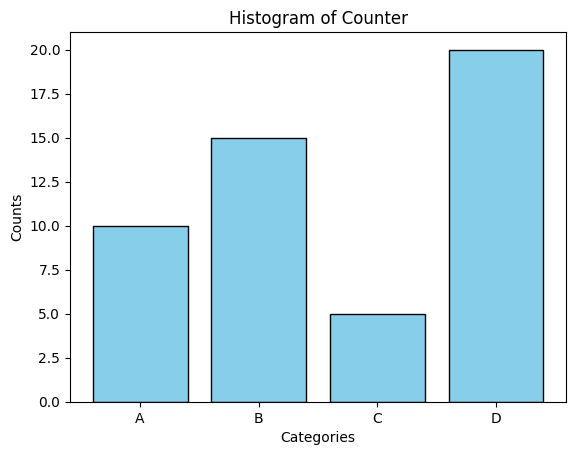

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

# 示例 Counter 对象
data = Counter({'A': 10, 'B': 15, 'C': 5, 'D': 20})

# 绘制直方图
def plot_counter_histogram(counter_obj):
    labels = list(counter_obj.keys())
    values = list(counter_obj.values())

    plt.bar(labels, values, color='skyblue', edgecolor='black')
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Histogram of Counter')
    plt.show()

# 调用函数绘制
plot_counter_histogram(data)

In [4]:
import torch
import torch.nn as nn

# 创建一个 Linear 层
linear = nn.Linear(in_features=10, out_features=5)

# 初始化输入
x = torch.randn(1, 10)

# 前向计算
output = linear(x)

# 钩子函数：仅保留第 i 个神经元的梯度
i = 2
def hook_fn(grad):
    mask = torch.zeros_like(grad)
    mask[i, :] = 1  # 仅保留第 i 行的梯度
    return grad * mask

linear.weight.register_hook(hook_fn)

# 损失函数
loss = output.sum()

# 反向传播
loss.backward()

# 查看梯度
print(linear.weight.grad)


tensor([[ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.7593, -0.1422, -0.8351, -0.6397, -0.1545, -1.1371, -0.7905,  0.8253,
          1.0648,  0.4474],
        [ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
          0.0000,  0.0000]])


In [10]:
from torch.utils.collect_env import main
main()


PyTorch version: 2.6.0a0+df5bbc09d1.nv24.11
Is debug build: False
CUDA used to build PyTorch: 12.6
ROCM used to build PyTorch: N/A

OS: Ubuntu 24.04.1 LTS (x86_64)
GCC version: (Ubuntu 13.2.0-23ubuntu4) 13.2.0
Clang version: Could not collect
CMake version: version 3.31.0
Libc version: glibc-2.39

Python version: 3.12.3 (main, Sep 11 2024, 14:17:37) [GCC 13.2.0] (64-bit runtime)
Python platform: Linux-6.8.0-51-generic-x86_64-with-glibc2.39
Is CUDA available: True
CUDA runtime version: Could not collect
CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA GeForce RTX 4090
Nvidia driver version: 560.35.05
cuDNN version: Probably one of the following:
/usr/lib/x86_64-linux-gnu/libcudnn.so.9.5.1
/usr/lib/x86_64-linux-gnu/libcudnn_adv.so.9.5.1
/usr/lib/x86_64-linux-gnu/libcudnn_cnn.so.9.5.1
/usr/lib/x86_64-linux-gnu/libcudnn_engines_precompiled.so.9.5.1
/usr/lib/x86_64-linux-gnu/libcudnn_engines_runtime_compiled.so.9.5.1
/usr/lib/x86_64-linux-gnu/libcudnn_graph.so.9.

In [6]:
from datasets import load_dataset

dataset = load_dataset("glue", "sst2")
train_labels = dataset['train']['label']

print(f"Train labels range: min = {min(train_labels)}, max = {max(train_labels)}")


Generating test split: 100%|██████████| 1821/1821 [00:00<00:00, 212315.22 examples/s]

Train labels range: min = 0, max = 1


In [12]:
from transformers import BertForMaskedLM
import torch
import torch.nn as nn


from transformers import BertForMaskedLM
import torch

from transformers import BertForMaskedLM
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomBertForMaskedLM(BertForMaskedLM):
    def __init__(self, config):
        super().__init__(config)
        self._intermediate_activations = []
        self._original_activations = []
        self._mask_logits = None
        self._partitioning_activations = []
        self._partitioning_step = []
        self._partitioning_logits = []

    def forward(self, *args, **kwargs):
        """
        保存现有参数以用于forward_with_partitioning
        """
        self._args = args
        self._kwargs = kwargs

        # Hook to capture intermediate activations
        def hook_fn(module, input, output):
            # 如果 _intermediate_activations 不为空，则清空它
            if len(self._intermediate_activations) == self.config.num_hidden_layers:
                self._intermediate_activations.clear()

            # 添加新的激活到 _intermediate_activations
            self._intermediate_activations.append(output.detach().cpu())

        # Register hooks on intermediate layers
        hooks = []
        for layer in self.bert.encoder.layer:
            hooks.append(layer.intermediate.register_forward_hook(hook_fn))

        # Forward pass
        outputs = super().forward(*args, **kwargs)
        # Remove hooks after forward pass
        for hook in hooks:
            hook.remove()

        return outputs

    def forward_with_partitioning(self, target_position=3):
        """
        target_pos token idx
        """
        for layer in self._intermediate_activations:
            target_vector = layer[:, target_position, :]
            partitioning, step = self.generate_partitioning(target_vector)
            self._partitioning_activations.append(partitioning.detach().cpu())
            self._partitioning_step.append(step.detach().cpu())

        # Forward pass
        for idx in range(self.config.num_hidden_layers):
            self.modify_ffn_activation(
                idx, target_position, self._partitioning_activations[idx]
            )
            outputs = super().forward(*self._args, **self._kwargs)
            self._partitioning_logits.append(
                outputs.logits
            )  # logits不可使用detach，否则会导致梯度丢失
        
        pass


    def get_mask_logits(self, input_ids, attention_mask):
        """
        Returns logits at [MASK] positions for the given input.
        """
        self.eval()  # Ensure model is in eval mode
        with torch.no_grad():
            outputs = self.forward(
                input_ids=input_ids, attention_mask=attention_mask, return_dict=True
            )
            logits = outputs.logits

        # Find [MASK] token positions (token_id=103 for BERT by default)
        mask_token_id = 103
        # mask_token_id = self.config.mask_token_id
        mask_positions = input_ids == mask_token_id

        # Extract logits for [MASK] positions
        mask_logits = logits[mask_positions]

        return mask_logits

    @property
    def get_intermediate_activations(self):
        """
        Returns the intermediate neuron activations from the last forward pass.
        Raises an error if intermediate_activations is empty.
        """
        if not self._intermediate_activations:
            raise ValueError(
                "Intermediate activations are empty. Ensure that a forward pass has been performed."
            )
        return self._intermediate_activations

    @property
    def original_activations(self):
        """
        Returns the original (before modification) intermediate neuron activations.
        """
        if not self._original_activations:
            raise ValueError(
                "Original activations are empty. Ensure that a forward pass has been performed."
            )
        return self._original_activations

    @property
    def mask_logits(self):
        """
        Returns the logits at [MASK] positions from the last forward pass.
        Raises an error if _mask_logits is None.
        """
        if self._mask_logits is None:
            raise ValueError(
                "Mask logits are not available. Ensure that a forward pass has been performed with [MASK] tokens."
            )
        return self._mask_logits

    def modify_ffn_activation(self, layer_idx, target_position, new_activation):
        """
        Modifies the hidden activations of a specific FFN layer at a specific position in the model.
        Stores the original activations before modifying.

        Args:
            layer_idx (int): Index of the transformer layer to modify (0-indexed).
            target_position (tuple): A tuple specifying the target position (batch_idx, seq_idx).
            new_activation (torch.Tensor): The new activation values with shape matching the FFN layer output
                                            (e.g., [intermediate_size]).
        """
        if not isinstance(new_activation, torch.Tensor):
            raise ValueError("new_activation must be a torch.Tensor.")

        def hook_fn(module, input, output):
            # Store original activations before modification
            self._original_activations.append(output.detach().cpu())

            # Ensure the shape matches
            batch_idx, seq_idx = target_position
            if new_activation.shape != output[batch_idx, seq_idx].shape:
                raise ValueError(
                    f"Shape mismatch: Expected {output[batch_idx, seq_idx].shape}, "
                    f"but got {new_activation.shape}."
                )

            # Modify the activation at the target position
            output = output.clone()  # Clone to avoid in-place modification
            output[batch_idx, seq_idx] = new_activation
            return output

        # Register the hook
        hook = self.bert.encoder.layer[layer_idx].intermediate.register_forward_hook(
            hook_fn
        )
        """
        这个函数利用hook修改指定位置上的FFN层的激活值，并存储修改前的激活值。
        """
        return hook  # Return the hook handle for later removal if needed

    def generate_partitioning(self, vector, times=20):
        """
        生成一组按比例缩放的输入数据。

        参数:
            emb (torch.Tensor): 输入张量，形状为 (1, ffn_size)，表示一个基准向量。
            batch_size (int): 每个批次中的样本数量。
            num_batch (int): 批次的总数量。

        返回:
            partitioning (torch.Tensor): 形状为 (batch_size * num_batch, ffn_size) 的张量，包含生成的缩放输入。
            step (torch.Tensor): 每次增量的大小，形状为 (1, ffn_size)，表示每一步的变化量。
        equal partitioning

        """
        vector = vector
        # vector = vector.unsqueeze(0)
        baseline = torch.zeros_like(vector)  # (1, ffn_size)

        # step: 计算每一步的增量，即 emb 和 baseline 之间的差距除以总的样本数。
        # 这是为了确保从 baseline 到 emb 的变化是均匀的，按比例分配给每个样本。
        step = (vector - baseline) / times  # (1, ffn_size) # 每个分量上的间隔值

        # res: 使用 baseline 和 step 生成 scaled input 的列表。
        # 通过 torch.add 和 step * i 逐步构建每个样本的值，并将这些值沿着第一个维度 (batch_size * num_batch) 拼接。
        partitioning = torch.cat(
            [torch.add(baseline, step * i) for i in range(times)], dim=0
        )  # (step, ffn_size)

        # 返回生成的输入数据和每一步的增量。
        return partitioning, step[0]

    # @staticmethod
    def calulate_integrated_gradients(self, logits, target_label, partitioning, step):

        prob = F.softmax(logits, dim=1)
        o = torch.unbind(prob[:, target_label])
        gradient = torch.autograd.grad(o, partitioning).sequeeze(0)
        grad_summed = gradient.sum(dim=0)  # (ffn_size)
        ig_pred = grad_summed * step  # (ffn_size)
        return ig_pred


from transformers import BertTokenizer, BertConfig
from transformers import BertForMaskedLM
import torch
import numpy as np

# Assuming CustomBertForMaskedLM is defined as per the provided code


def test_custom_bert_for_masked_lm():
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained BERT model and tokenizer
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    config = BertConfig.from_pretrained(model_name)

    # Instantiate the model and move it to the appropriate device (CPU or GPU)
    model = CustomBertForMaskedLM(config).to(device)

    # Load pre-trained weights into the custom model
    model.bert.load_state_dict(
        BertForMaskedLM.from_pretrained(model_name).bert.state_dict()
    )

    # Tokenize some example input text with a [MASK] token
    text = "The quick brown fox jumps over the [MASK] dog."
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Move input tensors to the same device as the model
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Perform the first forward pass to get original logits (before modification)
    original_outputs = model(
        input_ids=input_ids, attention_mask=attention_mask, return_dict=True
    )
    original_logits = original_outputs.logits

    # Get the original logits for the [MASK] position
    mask_token_id = 103
    mask_positions = input_ids == mask_token_id
    original_mask_logits = original_logits[mask_positions]

    # Modify the activations of a specific FFN layer and position
    target_position = (
        0,
        5,
    )  # Example: batch_idx = 0, seq_idx = 5 (corresponding to the [MASK] token)
    new_activation = torch.randn(model.config.intermediate_size).to(
        device
    )  # Random tensor of appropriate size

    # Modify the activation in the 3rd transformer layer
    hook = model.modify_ffn_activation(
        layer_idx=2, target_position=target_position, new_activation=new_activation
    )

    # Perform the second forward pass after modification
    modified_outputs = model(
        input_ids=input_ids, attention_mask=attention_mask, return_dict=True
    )
    modified_logits = modified_outputs.logits

    # Get the modified logits for the [MASK] position
    modified_mask_logits = modified_logits[mask_positions]

    # Compare the logits before and after the modification
    difference = torch.abs(original_mask_logits - modified_mask_logits)
    forward_with_partitioning = model.forward_with_partitioning(target_position=5)
    # Print the results
    print("Original logits for [MASK] position:", original_mask_logits)
    print("Modified logits for [MASK] position:", modified_mask_logits)
    print("Difference between original and modified logits:", difference)
    print(f"Maximum difference: {difference.max()}")  # Print the maximum difference
    partitioning, step = model.generate_partitioning(new_activation, times=20)
    re = model.calulate_integrated_gradients(
        original_logits, target_label=0, partitioning=partitioning, step=step
    )
    # Optionally remove the hook after testing
    hook.remove()
    from pprint import pprint

    pprint(model)


test_custom_bert_for_masked_lm()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: cannot unpack non-iterable int object

In [1]:
import torch

# 打印显存统计信息
print(torch.cuda.memory_stats())


OrderedDict()


In [1]:
from transformers import BertForSequenceClassifications

# 加载第一个模型
fine_tuned_bert_model = BertForSequenceClassification.from_pretrained("/openbayes/home/ftg/results/agnews_checkpoint-22500")

# 加载第二个模型
fine_tuned_classifier_model = BertForSequenceClassification.from_pretrained("/openbayes/home/ftg/results/train_full_imdb")

# 新建一个 BertForSequenceClassification 实例
combined_model = BertForSequenceClassification.from_pretrained("bert-base-cased")

# 将 BertModel 的权重替换为第一个微调模型的权重
combined_model.bert = fine_tuned_bert_model.bert

# 将 classifier 的权重替换为第二个微调模型的权重
combined_model.classifier.load_state_dict(fine_tuned_classifier_model.classifier.state_dict())


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>